In [136]:
import pandas as pd
import numpy as np

# tools from sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve

#Logisitc regression
from sklearn.linear_model import LogisticRegression

# SVMs
from sklearn.svm import SVC
from sklearn import preprocessing

# XGBoost
import xgboost as xgb

# visualizations
import matplotlib.pyplot as plt

Reading in corrosion data with MSP frequencies

In [93]:
corrosion_data = pd.read_csv('../clean/predict_corrosive.csv')

In [97]:
corrosion_data.head()

,FVFVJD,HPXUXU,JDQGQG,JDUXHP,MQFVMQ,MQHPNV,MQJDHP,MQUXXU,MZJDTL,MZMZQG,...,MZVBTL,NVMQZJ,NVMZUX,NVZJVB,RTVBHP,UXMQHP,UXMQMZ,UXUXHP,XUXUJD,corrosion
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,232.0,0.0,239.0,0.0,0.0,0.0,0.0,False
1,0.0,0.0,0.0,137.0,0.0,8.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,213.0,0.0,0.0,0.0,0.0,False


Splitting data into train/test sets (35% holdout for model evaluation).  Setting a random state to reproduce results

In [99]:
x_train, x_test, y_train, y_test = train_test_split(corrosion_data.drop('corrosion', axis = 1), corrosion_data['corrosion'], test_size=0.35, random_state=35)

First model: Logistic regression, penalizing using the l2 norm, using the default penalty parameter (C = 1)

In [100]:
log_reg = LogisticRegression(penalty = 'l2')

In [101]:
log_reg.fit(x_train, y_train)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [102]:
predictions = log_reg.predict(x_test)

In [109]:
print("Accuracy = {}".format(log_reg.score(x_test, y_test).round(3)))
print(classification_report(y_test,predictions))

Accuracy = 0.552
              precision    recall  f1-score   support

       False       0.54      0.73      0.62      2456
        True       0.58      0.37      0.45      2434

   micro avg       0.55      0.55      0.55      4890
   macro avg       0.56      0.55      0.54      4890
weighted avg       0.56      0.55      0.54      4890



As we can see, penalized losgistic regression does not do a good job of sperarating corrosion/non-corrosion actions based on MSP frequncy 30-days prior to the received data (55.3) accuracy.  However, our recall on negative classes is relatively good, as we can identify 73% of maintenance actions that do not target corrosion.  We will try some more complex model approaches next

Saving metrics for ROC curve

In [143]:
fpr_1, tpr_1, thresh_1 = metrics.roc_curve(y_test, predictions)
auc_1 = metrics.roc_auc_score(y_test, predictions)

Setting up the data matricies for XGBoost

In [105]:
D_train = xgb.DMatrix(x_train, label=y_train)
D_test = xgb.DMatrix(x_test, label=y_test)

/Applications/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Setting up the hyperparameters for XGBoost.  With more time, I would try some better approaches to select these parameters (cross-validation, grid search)

In [106]:
param = {
    'eta': 0.3, 
    'max_depth': 15,  
    'objective': 'binary:logistic'} 

steps = 15  # The number of training iterations

In [107]:
XG_boost = xgb.train(param, D_train, steps)

In [112]:
preds = XG_boost.predict(D_test)
print("Accuracy = {}".format(accuracy_score(y_test, preds > 0.5).round(3)))
print(classification_report(y_test, preds > 0.5))

Accuracy = 0.721
              precision    recall  f1-score   support

       False       0.73      0.71      0.72      2456
        True       0.72      0.73      0.72      2434

   micro avg       0.72      0.72      0.72      4890
   macro avg       0.72      0.72      0.72      4890
weighted avg       0.72      0.72      0.72      4890



XGBoost performs much better than logistic regression, with 72% accuracy.  WIth more time for hyperparamter tuning, this model could be improved.  This classification could be helpful in quickly diagnosing maintence issues prior to inspection based on recent MSP code frequncy

Saving metrics for ROC curve

In [144]:
fpr_2, tpr_2, thresh_2 = metrics.roc_curve(y_test, preds)
auc_2 = metrics.roc_auc_score(y_test, preds)

Next we will try using support-vector matrices (SVMs)

Preprossing for SVMs includes scaling the data, which is done below.  The scaler is saved to scale the test data

In [113]:
x_scaled = preprocessing.scale(x_train)
scaler = preprocessing.StandardScaler().fit(x_train)

Training an SVM with a linear kernal

In [129]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(x_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Scaling the test data, predicitng the classes

In [130]:
scaler.transform(x_test)
y_pred = svclassifier.predict(x_test)

In [131]:
print("Accuracy = {}".format(accuracy_score(y_test, y_pred).round(3)))
print(classification_report(y_test,y_pred))

Accuracy = 0.55
              precision    recall  f1-score   support

       False       0.56      0.52      0.54      2456
        True       0.54      0.58      0.56      2434

   micro avg       0.55      0.55      0.55      4890
   macro avg       0.55      0.55      0.55      4890
weighted avg       0.55      0.55      0.55      4890



SVM performance is similar to logistic regression, with accuracy about 55%.  Recall on the positive class (maintenance actions for corrosion) is 58%, which (if the model is improved) could be useful for technicians.

Saving metrics for ROC curve

In [145]:
fpr_3, tpr_3, thresh_3 = metrics.roc_curve(y_test, y_pred)
auc_3 = metrics.roc_auc_score(y_test, y_pred)

Plotting ROC curves for the three classification methods

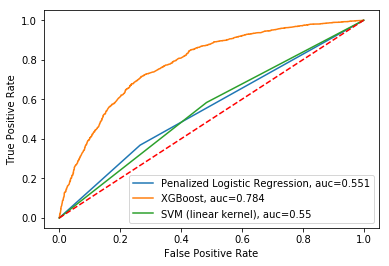

In [173]:
plt.plot(fpr_1,tpr_1,label="Penalized Logistic Regression, auc="+str(auc_1.round(3)))
plt.plot(fpr_2,tpr_2,label="XGBoost, auc="+str(auc_2.round(3)))
plt.plot(fpr_3,tpr_3,label="SVM (linear kernel), auc="+str(auc_3.round(3)))


plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc=0)
#plt.show()

plt.savefig('../ROC_curves.jpeg', quality = 95, dpi = 200)